# Timbre Encoder
This is the notebook used to train the Vocal Pitch Modulator.

This notebook makes use of the data to train our timbre encoder.

There are two models here, the first is a vowel classifier, that takes in an MFCC and outputs a vowel, and the second is a VAE that takes in an MFCC, reduces its dimensionality, and attempts to reconstruct the provided MFCC.

## Global variables/Imports
Run these cells before running either of the following sections.

In [34]:
%load_ext autoreload
%autoreload 1

import os
import csv

import scipy.io as sio
from scipy.io import wavfile
from scipy.io.wavfile import write

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

import time
import math

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss

from tqdm.notebook import trange, tqdm

from IPython.display import HTML
import warnings
from sklearn.preprocessing import OneHotEncoder

import torch
warnings.filterwarnings('ignore')
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

%aimport VPM
from VPM import *
%aimport Utils
from Utils import *
%aimport ANN
from ANN import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# Constants that should not change without the dataset being changed
n_pitches = 16
n_vowels = 12
n_people = 3

# These dictionaries are more for reference than anything
label_to_vowel = { 0: "bed",  1: "bird",   2: "boat",  3: "book", 
                   4: "cat",  5: "dog",    6: "feet",  7: "law",  
                   8: "moo",  9: "nut",   10: "pig",  11: "say" }

vowel_to_label = { "bed": 0,  "bird": 1,  "boat":  2, "book":  3,
                   "cat": 4,  "dog":  5,  "feet":  6, "law":   7,
                   "moo": 8,  "nut":  9,  "pig":  10, "say":  11}

noteidx_to_pitch = {  0: "A2",   1: "Bb2",  2: "B2",   3: "C3",
                      4: "Db3",  5: "D3",   6: "Eb3",  7: "E3", 
                      8: "F3",   9: "Gb3", 10: "G3",  11: "Ab3",
                     12: "A3",  13: "Bb3", 14: "B3",  15: "C4" }

### Constants
Used to tune the data generation and ANN.

In [36]:
n_mels = 128
n_mfcc = 20

### Data Generation
This is all the code that was explained in the Data Walkthrough. It generates data structures to hold all wav file data, spectrograms, mel spectra and MFCC data for all wav files.

For diagram-visualization of the data set, refer to the [readme](https://github.com/zioul123/VocalPitchModulator/blob/master/README.md).

For the classifier, MFCC are normalized by row to `[-1, 1]`, as the classifer can learn it better.
For the VAE, MFCC are normalized by row to `[0, 1]`, to allow the VAE to output it.

In [37]:
# File reference lists
data_ref_list = create_data_ref_list(os.path.join("Data", 'dataset_files.csv'),
                            n_pitches, n_vowels, n_people)
# flat_data_ref_list[flat_ref_idx(vowel, pitch, person)]
flat_data_ref_list = flatten_3d_array(data_ref_list, 
                                      n_vowels, n_pitches, n_people)

# File reference list accessors
# Returns a flat_ref_idx, given a vowel, pitch, person
flat_ref_idx = lambda vowel, pitch, person: flat_3d_array_idx(
    vowel, pitch, person, n_vowels, n_pitches, n_people)
# Returns vowel, pitch, person, given a flat_ref_idx
nd_ref_idx = lambda idx: nd_array_idx(idx, n_vowels, n_pitches, n_people)

# Data-label pairs for pitch-shift training - not used here
# data_label_pairs, _ = create_data_label_pairs(n_pitches)

# wav, spectrogram, mels, mfcc for each file in flat_data_ref_list
# wav_data:     (576, ~29400)  (n_wavs, n_samples)
# spectrograms: (576, 513, 58) (n_wavs, n_freq_bins, n_windows)
# mels:         (576, 128, 58) (n_wavs, n_mels, n_windows)
# mfccs:        (576, 20, 58)  (n_wavs, n_mfcc, n_windows)
all_wav_data = load_wav_files(os.path.join("Data", "dataset"), 
                              flat_data_ref_list)
all_spectrograms = np.array([ stft(waveform, plot=False) 
                              for waveform in all_wav_data ])
all_mels, all_mfcc = map(np.array, map(list, zip(*
                         [ ffts_to_mel(ffts, n_mels = n_mels, n_mfcc = n_mfcc) 
                           for ffts in all_spectrograms ])))

### Data-Label Structuring
This puts together the actual data-label pairs to be fed into the ANN.

Generate `data` and `labels` from `all_mfcc` and using `nd_ref_idx`.

In [39]:
n_files, n_mfcc_dummy, n_windows = all_mfcc.shape

# vowel_labels: (576) (n_wavs)
all_vowel_labels, _, _ = map(np.array, map(list, zip(*
                         [ nd_ref_idx(idx) 
                           for idx in range(len(flat_data_ref_list)) ])))

# Returns a flat 2d idx, given a wavfile index and a window index
flat_data_idx = lambda wav_idx, win_idx: flat_2d_array_idx(
    wav_idx, win_idx, n_files, n_windows)

# data:   (33408, 20) (n_wavs * n_windows, n_mfcc)
# labels: (33408) (n_wavs * n_windows)
data_prenorm = np.array([ all_mfcc[wav_file_idx][:, window_idx] 
                          for wav_file_idx in range(n_files) 
                          for window_idx in range(n_windows) ])
labels = np.array([ all_vowel_labels[wav_file_idx]
                    for wav_file_idx in range(n_files)
                    for window_idx in range(n_windows) ])

**Comment one of these lines**

In [40]:
#Normalize each mfcc (i.e. rows of the all_mfcc array) to [-1,1] - USE FOR THE CLASSIFER (TimbreEncoder)
# data = normalize_rows(data_prenorm, NormMode.REAL_TO_NEG_ONE_ONE)
#Normalize each mfcc (i.e. rows of the all_mfcc array) to [0,1] - USE FOR THE VAE (TimbreVAE)
data, scale = normalize_rows(data_prenorm, NormMode.REAL_TO_ZERO_ONE)

In [53]:
# You can retrieve the mfccs as follows:
# wav_idx = 0
# print((data[wav_idx] * 2 - 1) / scale[wav_idx])
# print(data_prenorm[wav_idx])

In [54]:
# These assertions no longer work after normalization, you can do them if you do not normalize the data array.
# # For testing purposes - verify that the mfcc have been arranged in order of
# # wav_idx, win_idx, mel_feature_idx
# for wav_idx in range(n_files):
#     for win_idx in range(n_windows):
#         for m in range(n_mfcc_dummy):
#             assert data[flat_data_idx(wav_idx, win_idx)][m] == \
#                    all_mfcc[wav_idx][m][win_idx]
# # Verify that the labels are arranged in order of wav_idx, win_idx
# for wav_idx in range(n_files):
#     for win_idx in range(n_windows):
#         assert labels[flat_data_idx(wav_idx, win_idx)] == \
#                all_vowel_labels[wav_idx]

Split Data into `train` and `test`, and convert to Torch tensors of the correct types. Run **only one of these cells.**

First method (**not-recommended**, simple): Random sampling to train and test

In [ ]:
# X_train, Y_train: (25056, 20) (25056) 
# X_val, Y_val:     (8352, 20) (8352)
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))
# Default tensor is float
X_train = X_train.float(); X_val = X_val.float()
# Used as index, so it is long
Y_train = Y_train.long(); Y_val = Y_val.long()

Second method **(recommended)**: 1 person from each wav will be the test data

In [20]:
# X_train, Y_train: (22272, 20) (22272,) 
# X_val, Y_val:     (11136, 20) (11136,)
X_train = []; X_val = []; Y_train = []; Y_val = []
for vow_idx in range(n_vowels):
    for pit_idx in range(n_pitches):
        # Choose the person for this pitch/vowel to be used as test data
        test_pid = int(np.random.rand() * 3)
        for pid_idx in range(n_people):
            wav_idx = flat_ref_idx(vow_idx, pit_idx, pid_idx)
            if (pid_idx != test_pid):
                for win_idx in range(n_windows):
                    X_train.append(data[flat_data_idx(wav_idx, win_idx)])
                    Y_train.append(labels[flat_data_idx(wav_idx, win_idx)])
            else:
                for win_idx in range(n_windows):
                    X_val.append(data[flat_data_idx(wav_idx, win_idx)])
                    Y_val.append(labels[flat_data_idx(wav_idx, win_idx)])  
X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))
# Default tensor is float
X_train = X_train.float(); X_val = X_val.float()
# Used as index, so it is long
Y_train = Y_train.long(); Y_val = Y_val.long()

### Timbre-Encoder - MFCC -> Vowel
This takes MFCC (and mel-spectrograms in future?), and tries to identify the vowel spoken.

**Results:**
```
| epochs | n_mfcc | n_hid | n_timb | Val acc |
|   5000 |     20 |    12 |      4 | 0.77898 |
```

In [ ]:
n_hid = 12; n_timb = 4; lr = 0.2; n_epochs = 5000;

# Training model 
model = TimbreEncoder(n_mfcc=n_mfcc, n_hid=n_hid, n_timb=n_timb, n_vowels=n_vowels)
# Define loss 
loss_fn = F.cross_entropy

In [ ]:
print("GPU Available" if torch.cuda.is_available() else "GPU Not available")

In [ ]:
# Use GPU if possible (will run on CPU otherwise)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move inputs to GPU (if possible)
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)

# Move the network to GPU (if possible)
model.to(device) 
# Define optimizer 
# opt = optim.SGD(model.parameters(), lr=lr)
opt = optim.Adam(model.parameters(), lr=lr)

# Fit the model
tic = time.time()
loss = model.train_func(X_train, Y_train, X_val, Y_val, model, opt,
                        loss_fn, epochs=n_epochs, print_graph=True)
toc = time.time()
print('Final loss: {}\nTime taken: {}'.format(loss, toc - tic))

Saving the model

In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
model_path = os.path.join("model_data", "TimbreEncoder_{}_{}_{}_{}_{}_{}.pt"
                          .format(lr, n_epochs, n_mfcc, n_hid, n_timb, loss))
torch.save(model.state_dict(), model_path)
print("Model saved at {}".format(model_path))

Loading the saved model, and using the model for prediction (whole dataset) example

In [ ]:
model = TimbreEncoder(n_mfcc=n_mfcc, n_hid=n_hid, n_timb=n_timb, n_vowels=n_vowels)
model.load_state_dict(torch.load(model_path))
model.eval()
# model.to(device)

data_tensor, label_tensor = map(torch.tensor, (data, labels))
data_tensor = data_tensor.float(); label_tensor = label_tensor.long(); 
# data_tensor = data_tensor.to(device); label_tensor = label_tensor.to(device)

correct = 0; wrong = 0;
corrects = np.zeros(n_vowels); wrongs = np.zeros(n_vowels)
predictions = np.zeros((n_vowels, n_vowels));
for vowel_idx in range(n_vowels):
    for pitch_idx in range(n_pitches):
        for pid_idx in range(n_people):
            wav_idx = flat_ref_idx(vowel_idx, pitch_idx, pid_idx)
            for win_idx in range(n_windows):
                data_idx = flat_data_idx(wav_idx, win_idx)
                label = (label_tensor[data_idx]).item()
                pred = (torch.argmax(model(data_tensor[data_idx]))).item()
                
                predictions[vowel_idx][pred] = predictions[vowel_idx][pred] + 1
                if label == pred:
                    correct = correct + 1
                    corrects[vowel_idx] = corrects[vowel_idx] + 1
                else:
                    wrong = wrong + 1
                    wrongs[vowel_idx] = wrongs[vowel_idx] + 1
                    
print("Total Accuracy: {}"
      .format(correct / (wrong + correct)))
for vowel_idx in range(n_vowels):
    print("Vowel: {}. Accuracy: {}. Most common pred: {}"
          .format(label_to_vowel[vowel_idx],
                  corrects[vowel_idx] / (wrongs[vowel_idx] + corrects[vowel_idx]),
                  label_to_vowel[np.argmax(predictions[vowel_idx])]))


### Timbre-VAE - MFCC -> MFCC
This takes MFCC, reduces dimensionality to a `n_timb` latent space, and attempts to recreate the MFCC.

In [23]:
n_hid = 10; n_timb = 4; lr = 1e-3; n_epochs = 10000; batch_size=22272

# Training model 
model = TimbreVAE(n_mfcc=n_mfcc, n_hid=n_hid, n_timb=n_timb)

# Define loss - from pytorch VAE example.
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [24]:
print("GPU Available" if torch.cuda.is_available() else "GPU Not available")

GPU Available


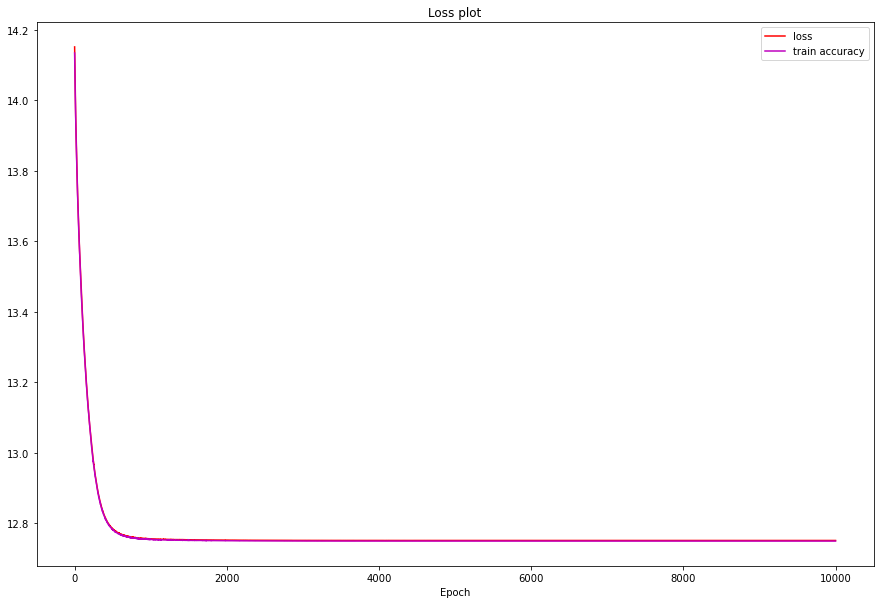

Training Loss before/after: 14.152216067259339, 12.750126279633621
Validation Loss before/after: 14.134939610272989, 12.748387830010776
Final loss: (12.750126279633621, 12.748378008261493)
Time taken: 95.22735357284546


In [25]:
# Use GPU if possible (will run on CPU otherwise)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move inputs to GPU (if possible)
X_train = X_train.to(device)
X_val = X_val.to(device)

# Move the network to GPU (if possible)
model.to(device) 
# Define optimizer 
# opt = optim.SGD(model.parameters(), lr=lr)
opt = optim.Adam(model.parameters(), lr=lr)

# Fit the model
tic = time.time()
loss = model.train_func(X_train, X_val, model, opt, loss_fn, batch_size=batch_size,
                        epochs=n_epochs, print_graph = True)
toc = time.time()
print('Final loss: {}\nTime taken: {}'.format(loss, toc - tic))

Saving the model

In [26]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
model_path = os.path.join("model_data", "TimbreVAE_lr{}_n_epochs{}_n_mfcc{}_n_hid{}_n_timb{}_{}.pt"
                          .format(lr, n_epochs, n_mfcc, n_hid, n_timb, loss))
torch.save(model.state_dict(), model_path)
print("Model saved at {}".format(model_path))

Model's state_dict:
en1.weight 	 torch.Size([10, 20])
en1.bias 	 torch.Size([10])
en_mu.weight 	 torch.Size([4, 10])
en_mu.bias 	 torch.Size([4])
en_std.weight 	 torch.Size([4, 10])
en_std.bias 	 torch.Size([4])
de1.weight 	 torch.Size([10, 4])
de1.bias 	 torch.Size([10])
de2.weight 	 torch.Size([20, 10])
de2.bias 	 torch.Size([20])
Model saved at model_data\TimbreVAE_lr0.001_n_epochs10000_n_mfcc20_n_hid10_n_timb4_(12.750126279633621, 12.748378008261493).pt


Loading the saved model, and using the model for prediction example

In [46]:
model = TimbreVAE(n_mfcc=n_mfcc, n_hid=n_hid, n_timb=n_timb)
model.load_state_dict(torch.load(model_path))
model.eval()

data_tensor = torch.tensor(data)
data_tensor = data_tensor.float();

wav_idx = flat_ref_idx(5, 5, 1)
data_idx = flat_data_idx(wav_idx, 30)
label = data_tensor[data_idx]
pred = model(data_tensor[data_idx])


# Rescaling the data array is the same as prenorm
print((data[data_idx] * 2 - 1) / scale[data_idx]) 
print(data_prenorm[data_idx])
# We see the prediction is roughly on the same order of magnitude as prenorm -> Autoencoder is successful
np.set_printoptions(suppress=True)
print((pred[0].detach().numpy() * 2 - 1) / scale[data_idx])

[-254.13701    241.4798       1.799128    38.29932      6.9060698
  -45.34479    -47.308533    10.779621    44.913612   -30.398193
  -24.722454    -3.5992258  -18.537493   -16.140165     8.499067
  -14.776051    17.55851     16.277525   -19.305908    -4.0421457]
[-254.13702    241.47981      1.7991194   38.29932      6.9060593
  -45.34479    -47.30854     10.779635    44.91362    -30.398193
  -24.722454    -3.5992284  -18.537493   -16.14016      8.499054
  -14.776056    17.558506    16.27752    -19.305904    -4.0421457]

[-242.87985     226.72884     -34.92098      33.24506       5.3138595
   -3.28491     -36.46167      -4.0434184    -0.23548687  -31.024675
  -14.2286415    -7.1847577    -9.985894    -13.498308     -4.9755044
   -8.887683     -1.1321728    -3.7054567    -5.773321    -12.994539  ]


## Experiment: Choosing `n_hid`, `n_timb`

From running this, we find the results:
Best `n_hid`: 10, Best `n_timb`: 4

In [47]:
# Define loss - from pytorch VAE example.
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

n_hid_candidates = [6, 8, 10, 12, 14, 16, 18]
n_timb_candidates = [4, 6, 8, 10, 12, 14, 16]
lr = 1e-3; n_epochs = 2500; batch_size=22272
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

losses = []
for hid_idx in range(len(n_hid_candidates)):
    for timb_idx in range(len(n_timb_candidates)):
        if (hid_idx < timb_idx): continue
        n_hid = n_hid_candidates[hid_idx]
        n_timb = n_timb_candidates[timb_idx]
        
        # Training model 
        model = TimbreVAE(n_mfcc=n_mfcc, n_hid=n_hid, n_timb=n_timb)

        X_train = X_train.to(device)
        X_val = X_val.to(device)
        model.to(device) 
        # opt = optim.SGD(model.parameters(), lr=lr)
        opt = optim.Adam(model.parameters(), lr=lr)

        # Fit the model
        tic = time.time()
        loss, val_loss = model.train_func(X_train, X_val, model, opt, loss_fn, batch_size=batch_size,
                                epochs=n_epochs, print_graph=False, desc="n_hid: {}, n_timb: {}".format(n_hid, n_timb))
        toc = time.time()
        print('n_hid: {}, n_timb: {}, Final val loss: {}, Time taken: {}'.format(n_hid, n_timb, val_loss, toc - tic))
        model_path = os.path.join("model_data", "TimbreVAE_EXPT_n_hid_n_timb_experiment_{}_{}_{}.pt"
                                  .format(n_hid, n_timb, val_loss))
        torch.save(model.state_dict(), model_path)
        print("Model saved at {}".format(model_path)) 
        losses.append(val_loss)


n_hid: 6, n_timb: 4, Final val loss: 12.749682897808908, Time taken: 19.85393738746643
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_6_4_12.749682897808908.pt



n_hid: 8, n_timb: 4, Final val loss: 12.75012487652658, Time taken: 18.63666820526123
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_8_4_12.75012487652658.pt



n_hid: 8, n_timb: 6, Final val loss: 12.751053733387213, Time taken: 18.740490198135376
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_8_6_12.751053733387213.pt



n_hid: 10, n_timb: 4, Final val loss: 12.748828405621408, Time taken: 19.146907567977905
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_10_4_12.748828405621408.pt



n_hid: 10, n_timb: 6, Final val loss: 12.750084186422415, Time taken: 21.91523814201355
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_10_6_12.750084186422415.pt



n_hid: 10, n_timb: 8, Final val loss: 12.749841448904453, Time taken: 21.23058032989502
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_10_8_12.749841448904453.pt



n_hid: 12, n_timb: 4, Final val loss: 12.749834433369253, Time taken: 22.319886922836304
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_12_4_12.749834433369253.pt



n_hid: 12, n_timb: 6, Final val loss: 12.749956503681753, Time taken: 20.11144781112671
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_12_6_12.749956503681753.pt



n_hid: 12, n_timb: 8, Final val loss: 12.751195447198276, Time taken: 19.888671875
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_12_8_12.751195447198276.pt



n_hid: 12, n_timb: 10, Final val loss: 12.75073101876796, Time taken: 24.067354202270508
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_12_10_12.75073101876796.pt



n_hid: 14, n_timb: 4, Final val loss: 12.74981478987069, Time taken: 21.181243181228638
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_14_4_12.74981478987069.pt



n_hid: 14, n_timb: 6, Final val loss: 12.749259159482758, Time taken: 23.346937656402588
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_14_6_12.749259159482758.pt



n_hid: 14, n_timb: 8, Final val loss: 12.750991996677442, Time taken: 22.373285055160522
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_14_8_12.750991996677442.pt



n_hid: 14, n_timb: 10, Final val loss: 12.74981058054957, Time taken: 22.019381999969482
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_14_10_12.74981058054957.pt



n_hid: 14, n_timb: 12, Final val loss: 12.751274021192529, Time taken: 21.046178579330444
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_14_12_12.751274021192529.pt



n_hid: 16, n_timb: 4, Final val loss: 12.749685704022989, Time taken: 20.65230703353882
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_16_4_12.749685704022989.pt



n_hid: 16, n_timb: 6, Final val loss: 12.75018521012931, Time taken: 20.2109158039093
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_16_6_12.75018521012931.pt



n_hid: 16, n_timb: 8, Final val loss: 12.750955515894397, Time taken: 21.95601201057434
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_16_8_12.750955515894397.pt



n_hid: 16, n_timb: 10, Final val loss: 12.74969552577227, Time taken: 23.390918016433716
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_16_10_12.74969552577227.pt



n_hid: 16, n_timb: 12, Final val loss: 12.75029886179957, Time taken: 21.056029796600342
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_16_12_12.75029886179957.pt



n_hid: 16, n_timb: 14, Final val loss: 12.750889569863507, Time taken: 21.883458375930786
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_16_14_12.750889569863507.pt



n_hid: 18, n_timb: 4, Final val loss: 12.749797952586206, Time taken: 19.31596040725708
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_18_4_12.749797952586206.pt



n_hid: 18, n_timb: 6, Final val loss: 12.749281609195402, Time taken: 19.58797001838684
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_18_6_12.749281609195402.pt



n_hid: 18, n_timb: 8, Final val loss: 12.749684300915948, Time taken: 19.6473069190979
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_18_8_12.749684300915948.pt



n_hid: 18, n_timb: 10, Final val loss: 12.750893779184626, Time taken: 21.02516531944275
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_18_10_12.750893779184626.pt



n_hid: 18, n_timb: 12, Final val loss: 12.751188431663074, Time taken: 20.871736764907837
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_18_12_12.751188431663074.pt



n_hid: 18, n_timb: 14, Final val loss: 12.751575689206177, Time taken: 20.64602518081665
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_18_14_12.751575689206177.pt



n_hid: 18, n_timb: 16, Final val loss: 12.74988073590158, Time taken: 20.266278743743896
Model saved at model_data\TimbreVAE_EXPT_n_hid_n_timb_experiment_18_16_12.74988073590158.pt


In [49]:
indices = [ [n_hid_candidates[hid_idx], n_timb_candidates[timb_idx]] 
            for hid_idx in range(len(n_hid_candidates))
            for timb_idx in range(len(n_timb_candidates)) if (hid_idx >= timb_idx) ]
best_hid, best_timb = indices[np.argmin(np.array(losses))]
print("Best n_hid: {}, Best n_timb: {}".format(best_hid, best_timb))
print(np.array(list(zip(losses, indices))))

Best n_hid: 10, Best n_timb: 4
[[12.749682897808908 list([6, 4])]
 [12.75012487652658 list([8, 4])]
 [12.751053733387213 list([8, 6])]
 [12.748828405621408 list([10, 4])]
 [12.750084186422415 list([10, 6])]
 [12.749841448904453 list([10, 8])]
 [12.749834433369253 list([12, 4])]
 [12.749956503681753 list([12, 6])]
 [12.751195447198276 list([12, 8])]
 [12.75073101876796 list([12, 10])]
 [12.74981478987069 list([14, 4])]
 [12.749259159482758 list([14, 6])]
 [12.750991996677442 list([14, 8])]
 [12.74981058054957 list([14, 10])]
 [12.751274021192529 list([14, 12])]
 [12.749685704022989 list([16, 4])]
 [12.75018521012931 list([16, 6])]
 [12.750955515894397 list([16, 8])]
 [12.74969552577227 list([16, 10])]
 [12.75029886179957 list([16, 12])]
 [12.750889569863507 list([16, 14])]
 [12.749797952586206 list([18, 4])]
 [12.749281609195402 list([18, 6])]
 [12.749684300915948 list([18, 8])]
 [12.750893779184626 list([18, 10])]
 [12.751188431663074 list([18, 12])]
 [12.751575689206177 list([18, 14])